# Re-implementation of neural tangents cookbook
## Bayesian Inference

In [15]:
import functools
import matplotlib.pyplot as plt
import jax.numpy as np

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')
  
legend = functools.partial(plt.legend, fontsize=10)

((5, 1), (50, 1))

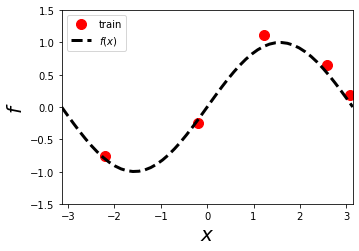

In [16]:
from data_loader import synthetic_dataset
train, test = synthetic_dataset()
train_xs, train_ys = train
test_xs, test_ys = test
plot_fn(train, test)
legend(loc="upper left")
finalize_plot((0.85, 0.6))
train_xs.shape, test_xs.shape

In [17]:
from models import FCN
from nngp import NNGP
from neural_tangents import stax
fcn = FCN(hid_dim=512, nonlinearity=stax.Erf)
nngp = NNGP(fcn)
prior_draws = nngp.random_draw(test_xs, 10)

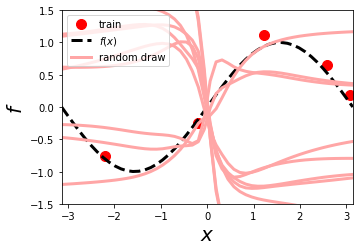

In [18]:
plot_fn(train, test)
for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])
    
legend(["train", "$f(x)$", "random draw"], loc="upper left")

finalize_plot((0.85, 0.6))

In [19]:
std = nngp.get_std(test_xs)

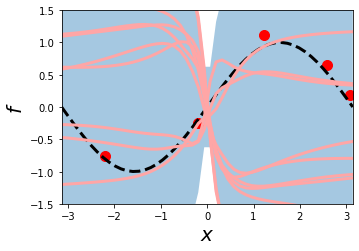

In [20]:
plot_fn(train, test)
plt.fill_between(np.reshape(test_xs, (-1,)), 2 * std, -2 * std, alpha=0.4)
for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

In [21]:
nngp.fit(*train)
nngp_mean, nngp_cov = nngp.inference(test_xs)
nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_cov))

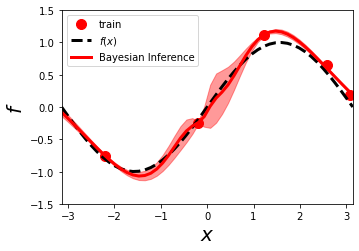

In [22]:
plot_fn(train, test)
plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(np.reshape(test_xs, (-1,)), nngp_mean - 2 * nngp_std, nngp_mean + 2 * nngp_std, color='red', alpha=0.4)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(["train", "$f(x)$", "Bayesian Inference"], loc="upper left")

finalize_plot((0.85, 0.6))

In [23]:
ntk_mean, ntk_cov = nngp.inference(test_xs, ntk=True)
ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_cov))

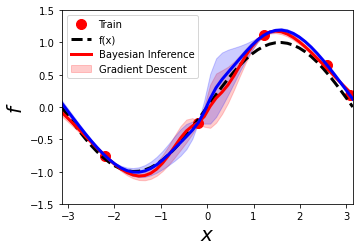

In [24]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

In [25]:
from metrics import mse_predict

ts = np.arange(0, 10**3, 10**-1) # (10000, )
ntk_train_loss_mean = nngp.compute_loss(mse_predict, train_ys, ts)
ntk_test_loss_mean = nngp.compute_loss(mse_predict, test_ys, ts, test_xs)

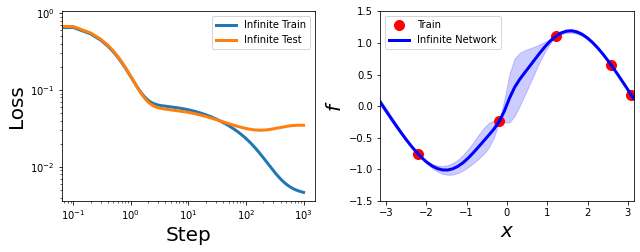

In [26]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))

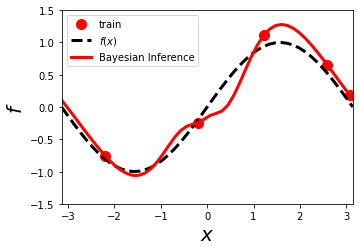

In [27]:
import neural_tangents as nt
k_train_train = fcn.kernel_fn(train_xs, None, "nngp")
k_test_train = fcn.kernel_fn(test_xs, train_xs, "nngp")
predict_fn = nt.predict.gradient_descent_mse(k_train_train, train_ys)
fx_train_0 = fcn.predict(train_xs)
fx_test_0 = fcn.predict(test_xs)
fx_train_t, fx_test_t = predict_fn(None, fx_train_0, fx_test_0, k_test_train)

plot_fn(train, test)
plt.plot(test_xs, fx_test_t, 'r-', linewidth=3)
# plt.fill_between(np.reshape(test_xs, (-1,)), snngp_mean - 2 * snngp_std, snngp_mean + 2 * snngp_std, color='red', alpha=0.4)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(["train", "$f(x)$", "Bayesian Inference"], loc="upper left")

finalize_plot((0.85, 0.6))

## Sparse Approximation

In [28]:
from snngp import SNNGP
from inducing_points import random_select

hyperparams = dict(
    hid_dim=512,
    nonlinearity=stax.Erf
)
# inducing_points = random_select(train_xs, 5)
snngp = SNNGP(model=FCN, hyper_params=hyperparams, train_data=(train_xs, train_ys.flatten()), inducing_points=train_xs, num_latent_gps=1)

interval = snngp.evaluate()
print(f"interval: {interval}")

snngp.optimize()

interval = snngp.evaluate()
print(f"interval: {interval}")

snngp_mean, snngp_cov = snngp.predict(test_xs)
snngp_mean = np.reshape(snngp_mean, (-1,))
snngp_std = np.sqrt(np.diag(snngp_cov))

/home/ycniu/anaconda3/envs/nngp-gpu/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


interval: 5.245208740234375e-06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03825D+00    |proj g|=  2.93917D-01

At iterate    1    f=  5.77037D+00    |proj g|=  2.67340D-01

At iterate    2    f=  5.48516D+00    |proj g|=  2.19097D-01

At iterate    3    f=  5.43613D+00    |proj g|=  1.21994D-01

At iterate    4    f=  5.42331D+00    |proj g|=  2.33136D-02

At iterate    5    f=  5.42279D+00    |proj g|=  1.13507D-03

At iterate    6    f=  5.42278D+00    |proj g|=  5.48295D-04

At iterate    7    f=  5.42277D+00    |proj g|=  1.97690D-03

At iterate    8    f=  5.42274D+00    |proj g|=  4.17264D-03

At iterate    9    f=  5.42268D+00    |proj g|=  5.56981D-03

At iterate   10    f=  5.42260D+00    |proj g|=  4.61628D-03

At iterate   11    f=  5.42254D+00    |proj g|=  1.66000D-03

At iterate   12    f=  5.42253D+00    |proj g|=  3.38468

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


interval: 4.291534423828125e-06


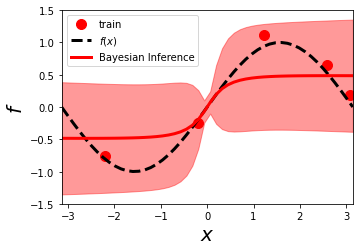

In [31]:
plot_fn((snngp.inducing_points, train_ys), test)
plt.plot(test_xs, snngp_mean, 'r-', linewidth=3)
plt.fill_between(np.reshape(test_xs, (-1,)), snngp_mean - 2 * snngp_std, snngp_mean + 2 * snngp_std, color='red', alpha=0.4)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(["train", "$f(x)$", "Bayesian Inference"], loc="upper left")

finalize_plot((0.85, 0.6))

## Fully Connected Nerual Networks

In [15]:
from nn import Trainer
from metrics import mse_loss
from jax.example_libraries import optimizers

epochs = 10000

optimizer = optimizers.sgd(0.1)
loss = mse_loss(fcn)
trainer = Trainer(fcn, epochs, 5, optimizer, loss)

opt_params, train_losses, test_losses = trainer.fit_small(train, test)

100%|██████████| 10000/10000 [00:47<00:00, 210.47it/s]


In [16]:
print(fcn.kernel_fn(train_xs, None, 'nngp'))

[[ 1.3201056   1.3133826  -1.2921144  -0.6002169   1.2353275 ]
 [ 1.3133826   1.308724   -1.2892504  -0.60428536  1.2391908 ]
 [-1.2921144  -1.2892504   1.2956082   0.62317157 -1.2284735 ]
 [-0.6002169  -0.60428536  0.62317157  0.43115342 -0.6214882 ]
 [ 1.2353275   1.2391908  -1.2284735  -0.6214882   1.2212756 ]]


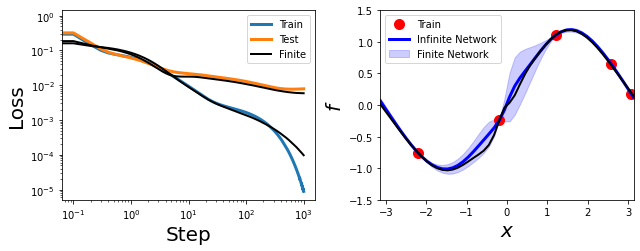

In [14]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, fcn.apply_fn(opt_params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [ ]:
params, train_loss, test_loss = trainer.fit(train, test)

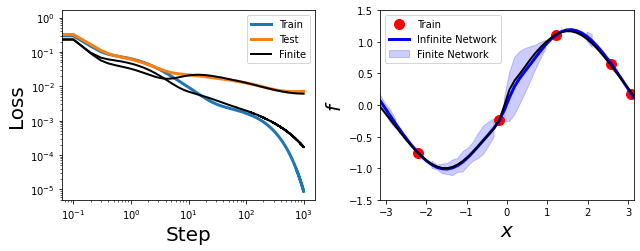

In [ ]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, fcn.apply_fn(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [ ]:
opt_params, train_loss, test_loss = trainer.fit(train, test)

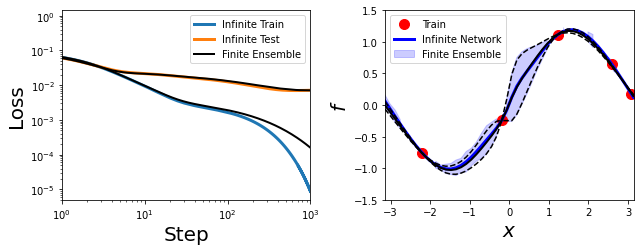

In [ ]:
from jax import vmap

plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(fcn.apply_fn, (0, None))(opt_params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

## Residual

In [ ]:
from models import ResFCN
from util import split_key

training_steps = 10000
ensemble_size = 100
learning_rate = 0.1
ts = np.arange(0, 10 ** 3, learning_rate)

resfcn = ResFCN()
loss = mse_loss(resfcn)
optimizer = optimizers.sgd(learning_rate)
trainer = Trainer(resfcn, training_steps, optimizer, loss)

key, = split_key(1)
params, train_loss, test_loss = trainer.fit(train, test, ensemble_size)

In [ ]:
nngp = NNGP(resfcn)
nngp.fit(train_xs, train_ys)
ntk_mean, ntk_cov = nngp.inference(test_xs, ntk=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_cov))

ntk_train_loss_mean = nngp.compute_loss(mse_predict, train_ys, ts)
ntk_test_loss_mean = nngp.compute_loss(mse_predict, test_ys, ts, test_xs)

/home/ycniu/anaconda3/envs/ic-project/lib/python3.8/site-packages/neural_tangents/_src/stax/branching.py:395: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


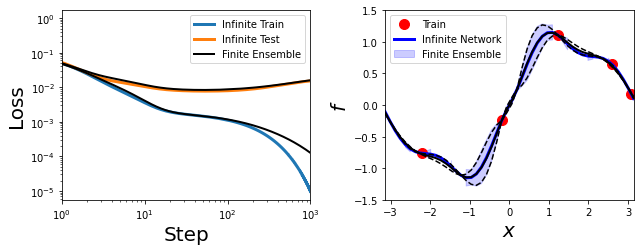

In [ ]:
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(resfcn.apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))
